# [활용] 자연어 처리 : 영화 리뷰 분석하기

In [15]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import utils

# 데이터 셋 다운

In [4]:
# 데이터 셋 다운 받기
data_set = tf.keras.utils.get_file(fname="imdb.tar.gz",
                                    origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                    extract = True)

# 데이터 셋으로 데이터 프레임 만들기
##### 데이터 셋 구성
- data_set(폴더)
    - aclImdb(폴더)
        - train(폴더)
            - pos(폴더)
            - neg(폴더)
        - test(폴더)
            - pos(폴더)
            - neg(폴더)

##### 함수 정의하기

In [3]:
# 데이터 읽고 데이터 프레임 만들기 함수
def directory_data(directory):
    data={}
    data['review']=[]
    
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path), 'r', encoding='utf=8') as file: # 파일 읽기
            data['review'].append(file.read()) # data['review']에 내용 저장하기
    return pd.DataFrame.from_dict(data) # 데이터 프레임 반환하기

# 긍정, 부정 데이터 프레임 만들기
def make_data(directory):
    pos_df = directory_data(os.path.join(directory, 'pos')) # 긍정적 데이터 프레임
    neg_df = directory_data(os.path.join(directory, 'neg')) # 부정적 데이터 프레임
    
    pos_df['sentiment']=1
    neg_df['sentiment']=0
    
    return pd.concat([pos_df, neg_df])

##### Train, Test 데이터 프레임 저장하기

In [5]:
train_df = make_data(os.path.join(os.path.dirname(data_set),"aclImdb","train"))
test_df = make_data(os.path.join(os.path.dirname(data_set),"aclImdb","test"))

##### 분리된 데이터 확인하기

In [6]:
test_df.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


# 데이터 내용 분석하기

In [9]:
import matplotlib.pyplot as plt

In [8]:
reviews = list(train_df['review'])
tokenized_reviews = [r.split() for r in reviews] # 문장별 띄어쓰기를 기준으로 단어 분리해주기

review_len_by_words = [len(t) for t in tokenized_reviews] # 문장별 토큰별 길이값 저장
review_len_by_alphabet = [len(s.replace(" ",'')) for s in reviews] # 문장별 글자의 개수 저장

##### 시각화

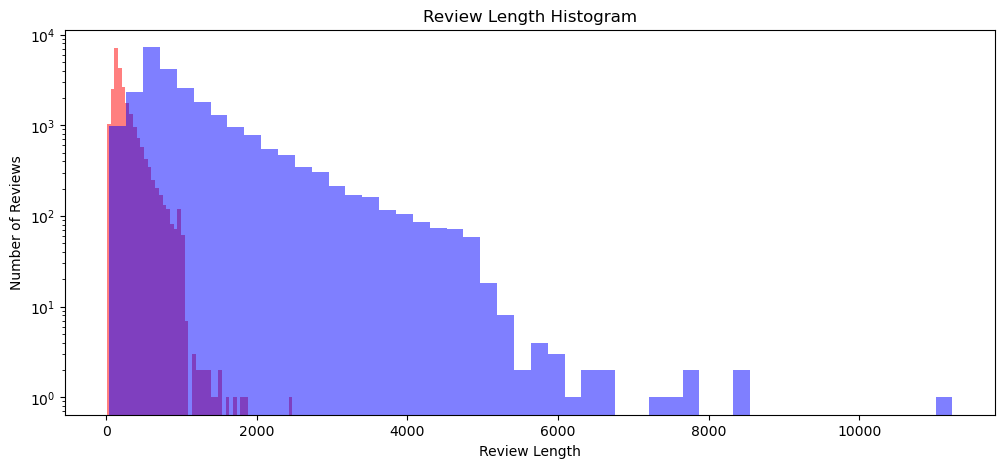

In [14]:
plt.figure(figsize=(12,5))

plt.hist(review_len_by_words, bins=50, alpha=0.5, color='r')
plt.hist(review_len_by_alphabet, bins=50, alpha=0.5, color='b')
plt.yscale('log')
plt.title("Review Length Histogram")
plt.xlabel('Review Length')
plt.ylabel("Number of Reviews")
plt.show()

##### 문장 분석

In [16]:
print(f"문장 최대 길이 : {np.max(review_len_by_words)}")
print(f"문장 최소 길이 : {np.min(review_len_by_words)}")
print(f"문장 평균 길이 : {np.mean(review_len_by_words)}")
print(f"문장 길이 표준편차 : {np.std(review_len_by_words)}")
print(f"문장 길이 중간값 : {np.median(review_len_by_words)}")
print(f"문장의 하위 10% 길이 : {np.percentile(review_len_by_words, 10)}")

문장 최대 길이 : 2470
문장 최소 길이 : 10
문장 평균 길이 : 233.7872
문장 길이 표준편차 : 173.72955740506566
문장 길이 중간값 : 174.0
문장의 하위 10% 길이 : 91.0
